In [31]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn.functional as F
from typing import Tuple
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
class PPO_Clip_Agent():
    """ Since the discrete actions have been redefined as {0,1} by env, we can simply represent the action by a number. """
    def __init__(self,
                 episode_recorder:object,
                 actor_network:torch.nn, 
                 critic_network:torch.nn,
                 actor_optimizer:torch.optim,
                 critic_optimizer:torch.optim,
                 gamma:float = 0.9,
                 advantage_lambda:float = 0.95,
                 clip_epsilon:float = 0.2, 
                 train_iters:int = 10, 
                 device:torch.device = torch.device("cpu")
                 ) -> None:
        
        self.device = device
        self.episode_recorder = episode_recorder
        self.actor_network = actor_network
        self.critic_network = critic_network
        self.actor_optimizer = actor_optimizer
        self.critic_optimizer = critic_optimizer              
        self.clip_epsilon = clip_epsilon
        self.train_iters = train_iters
        self.gamma = gamma
        self.advantage_lambda = advantage_lambda
        
    def get_action(self, obs:np.ndarray) -> Tuple[int, torch.tensor]:
        """ The output of policy network is the action distribution. 
            Apart from the sampled action, the sampled action distribution ( log_pi(s|a) ) is used for training the policy network."""
        
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        dist = self.critic_network(obs) # NN_outputs -softmax-> Action distribution
        # dist = F.softmax(dist, dim = 0) 
        action_probs = torch.distributions.Categorical(dist)
        picked_action = action_probs.sample()
        log_prob = action_probs.log_prob(picked_action).unsqueeze(0) 
               
        return picked_action.item(), log_prob
    
    def calculate_log_prob(self, obs:torch.tensor, action:torch.tensor) -> torch.tensor:
        # dist = F.softmax(self.actor_network(obs), dim=1)
        log_prob = torch.log(self.actor_network(obs).gather(1, action))
        
        return log_prob
        
    
    def calculate_advantage(self, td_error:torch.tensor) -> torch.tensor:
        """ The advantage function is calculated by the TD error. """
        td_error = td_error.cpu().detach().numpy()
        advantage_list = []
        advantage = 0.0
        for delta in td_error[::-1]:
            advantage = self.gamma * self.advantage_lambda * advantage + delta
            advantage_list.append(advantage)
        advantage_list.reverse()
        advantage = torch.tensor(advantage_list, dtype = torch.float32).to(self.device)
        
        return advantage
    
    def train_policy(self) -> None:
        obs, action, log_prob, reward, next_obs , done, = self.episode_recorder.get_trajectory()
        
        
        old_log_prob = log_prob.detach() # Freeze the log_prob obtained by the current policy
            
        current_V = self.critic_network(obs)
        next_V = self.critic_network(next_obs)
        TD_target = reward + self.gamma * next_V * (1 - done)
        TD_error = TD_target - current_V
        advantage = self.calculate_advantage(TD_error)
        
        for _ in range(self.train_iters):

            
            log_prob = self.calculate_log_prob(obs, action)
            ratio = torch.exp(log_prob - old_log_prob) # pi_theta / pi_theta_old
            # print(ratio)
            clipped_ratio = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon)
            actor_loss = torch.mean(-torch.min(ratio * advantage, clipped_ratio * advantage))
            
            critic_loss = torch.mean(F.mse_loss(TD_target.detach(), self.critic_network(obs)))
            
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
        
        

In [33]:
class Actor_Network(torch.nn.Module):

    def __init__(self,obs_dim:int,action_dim:int) -> None:
        super(Actor_Network, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,action_dim)
                    
    def forward(self,x:torch.tensor) -> torch.tensor:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
                
        return x
    
class Critic_Network(torch.nn.Module):

    def __init__(self,obs_dim:int) -> None:
        super(Critic_Network, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,1)
                    
    def forward(self,x:torch.tensor) -> torch.tensor:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
                
        return x

In [34]:
class Episode_Recorder():
    
    def __init__(self, device:torch.device = torch.device("cpu")) -> None:
        self.trajectory = {
            "obs": torch.tensor([], dtype = torch.float32).to(device),
            "action": torch.tensor([], dtype = torch.int64).to(device),
            "log_prob": torch.tensor([], dtype = torch.float32).to(device),
            "reward": torch.tensor([], dtype = torch.float32).to(device),
            "next_obs": torch.tensor([], dtype = torch.float32).to(device),
            "done": torch.tensor([], dtype = torch.float32).to(device)
        }
        self.device = device
        
    def append(self, 
               obs: np.ndarray,
               action: int,
               log_prob: torch.tensor,
               reward:float,
               next_obs: np.ndarray,
               done: bool
               ) -> None:
        obs = torch.tensor([obs], dtype = torch.float32).to(self.device)
        action = torch.tensor([[action]], dtype = torch.int64).to(self.device)
        reward = torch.tensor([[reward]], dtype = torch.float32).to(self.device)
        next_obs = torch.tensor([next_obs], dtype = torch.float32).to(self.device)
        done = torch.tensor([[done]], dtype = torch.float32).to(self.device)
        self.trajectory["obs"] = torch.cat((self.trajectory["obs"], obs))
        self.trajectory["action"] = torch.cat((self.trajectory["action"], action))
        self.trajectory["log_prob"] = torch.cat((self.trajectory["log_prob"], log_prob))
        self.trajectory["reward"] = torch.cat((self.trajectory["reward"], reward))
        self.trajectory["next_obs"] = torch.cat((self.trajectory["next_obs"], next_obs))
        self.trajectory["done"] = torch.cat((self.trajectory["done"], done))
        
        
    def get_trajectory(self) -> Tuple[torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor]:
        
        return self.trajectory["obs"], self.trajectory["action"], \
            self.trajectory["log_prob"], self.trajectory["reward"], \
            self.trajectory["next_obs"], self.trajectory["done"]
    
    def clear(self) -> None:
        """ Clear the trajectory when begin a new episode."""
        self.trajectory["obs"] = torch.tensor([], dtype = torch.float32).to(self.device)
        self.trajectory["action"] = torch.tensor([], dtype = torch.int64).to(self.device)
        self.trajectory["log_prob"] = torch.tensor([], dtype = torch.float32).to(self.device)
        self.trajectory["reward"] = torch.tensor([], dtype = torch.float32).to(self.device)
        self.trajectory["next_obs"] = torch.tensor([], dtype = torch.float32).to(self.device)
        self.trajectory["done"] = torch.tensor([], dtype = torch.float32).to(self.device)

In [35]:
class TrainManager():
    
    def __init__(self,
                 env:gym.Env,
                 episode_num:int = 1000,
                 actor_lr:float = 1e-4,
                 critic_lr:float = 1e-3,
                 gamma:float = 0.9,
                 advantage_lambda:float = 0.95,
                 clip_epsilon:float = 0.2,
                 train_iters:int = 10, 
                 seed = 0,
                 my_device = "cpu"
                 ) -> None:
        
        self.seed = seed
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(self.seed)
        torch.backends.cudnn.deterministic = True
        
        self.device = torch.device(my_device)
    
        self.env = env
        self.episode_num = episode_num
        obs_dim = gym.spaces.utils.flatdim(env.observation_space) 
        action_dim = env.action_space.n
        episode_recorder = Episode_Recorder(device = self.device)
        actor_network = Actor_Network(obs_dim,action_dim).to(self.device)
        actor_optimizer = torch.optim.Adam(actor_network.parameters(),lr=actor_lr)
        critic_network = Critic_Network(obs_dim).to(self.device)
        critic_optimizer = torch.optim.Adam(critic_network.parameters(),lr=critic_lr)
        self.agent = PPO_Clip_Agent(episode_recorder = episode_recorder,
                                    actor_network = actor_network, 
                                    critic_network = critic_network,
                                    actor_optimizer = actor_optimizer,
                                    critic_optimizer = critic_optimizer,
                                    gamma = gamma,
                                    advantage_lambda = advantage_lambda,
                                    clip_epsilon = clip_epsilon,
                                    train_iters = train_iters,
                                    device = self.device
                                    )
                                            
        self.episode_total_rewards = np.zeros(self.episode_num)
        self.index_episode = 0
        
    def train_episode(self,is_render:bool=False) -> float:
        total_reward = 0
        self.agent.episode_recorder.clear() 
        obs,_ = self.env.reset(seed=self.seed) 
        while True:
            action, log_prob = self.agent.get_action(obs) 
            next_obs, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            self.agent.episode_recorder.append(obs, action, log_prob, reward, next_obs, done)
            total_reward += reward 
            obs = next_obs
            if is_render:
                self.env.render()
                                
            if done:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
        
        self.agent.train_policy()
        
        return total_reward
    
    def train(self) -> None:      
        for e in range(self.episode_num):
            episode_reward = self.train_episode()
            if e%100 == 0:
                print('Episode %s: Total Reward = %.2f'%(e,episode_reward)) 
                        
    def plotting(self,smoothing_window:int = 100) -> None:
        """ Plot the episode reward over time. """
        fig = plt.figure(figsize=(10,5))
        plt.plot(self.episode_total_rewards,label="Episode Reward")
        # Use rolling mean to smooth the curve
        rewards_smoothed = pd.Series(self.episode_total_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed,label="Episode Reward (Smoothed)")
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.title("Episode Reward over Time")
        plt.legend()
        plt.show()

Episode 0: Total Reward = 11.00
Episode 100: Total Reward = 11.00
Episode 200: Total Reward = 11.00
Episode 300: Total Reward = 11.00
Episode 400: Total Reward = 11.00
Episode 500: Total Reward = 11.00
Episode 600: Total Reward = 11.00
Episode 700: Total Reward = 11.00
Episode 800: Total Reward = 11.00
Episode 900: Total Reward = 11.00


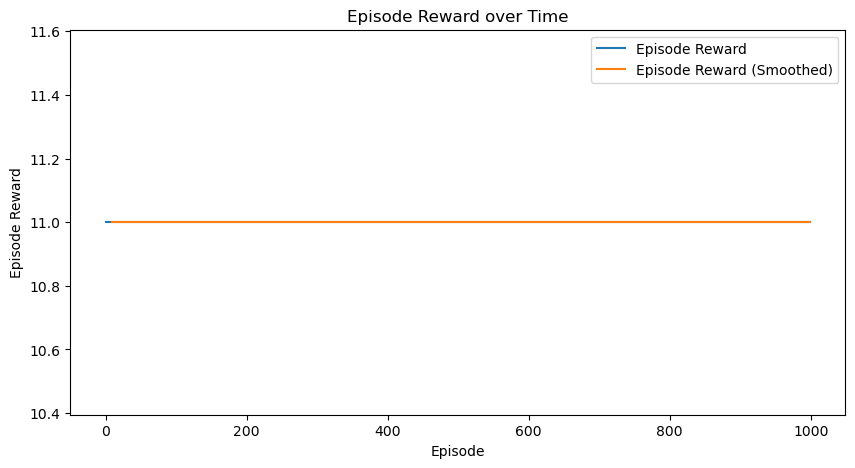

In [36]:
if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    Manger = TrainManager(env = env,
                        episode_num = 1000,
                        actor_lr = 1e-3,
                        critic_lr = 1e-2,
                        gamma = 0.98,
                        advantage_lambda = 0.95,
                        clip_epsilon = 0.2,
                        train_iters = 10, 
                        seed = 0,
                        my_device = "cpu" 
                        )
    Manger.train()
    Manger.plotting(smoothing_window = 10)